In [1]:
# THIS CELL SETS STUFF UP FOR DEMO / COLLAB. THIS CELL CAN BE IGNORED.

#-------------------------------------GET RID OF TF DEPRECATION WARNINGS--------------------------------------#
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#----------------------------------INSTALL PSYCHRNN IF IN A COLAB NOTEBOOK-------------------------------------#
# Installs the correct branch / release version based on the URL. If no branch is provided, loads from master.
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import json
    import re
    import ipykernel
    import requests 
    from requests.compat import urljoin

    from notebook.notebookapp import list_running_servers
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path'].split('%2F')
                if 'blob' in relative_path:
                  blob = relative_path[relative_path.index('blob') + 1]
                  !pip install git+https://github.com/murraylab/PsychRNN@$blob
                else:
                  !pip install git+https://github.com/murraylab/PsychRNN

# Define New Task

Below is a sample implentation of a simple perceptual discrimination task. The newly defined task implements and inherits from [Task](../apidoc/tasks.rst#module-psychrnn.tasks.task). Other examples of tasks are available [here](../apidoc/tasks.rst#implemented-example-tasks).

This task will involve two inputs and two outputs. The network must indicate which of the two inputs (directions) has larger signal, and the mean difference in magnitude of the two inputs will be indicated by coherence.

To define the task, ``generate_trial_params`` and ``trial_function`` are the two key functions that must be defined. 

In this simple task, ``generate_trial_params`` assigns both the direction and the coherence of the trial randomly.

``trial_function`` is given a time point indicating what time in the trial it is currently at as well as the output from ``generate_trial_params``. The function intializes the input, ``x_t``, with noise, the output, ``y_t``, with zeros, and the mask, ``mask_t`` with ones. During the stimulus period, ``x_t`` has input signal added to it. During the response period, ``y_t[direction]`` is set to 1 to indicate the correct direction of the stimulus. Before and during the stimlus period, the mask is set to 0 so that when training, the network knows not to care about it's outputs before the response period.



In [2]:
from psychrnn.tasks.task import Task
import numpy as np


class SimplePD(Task):
    def __init__(self, dt, tau, T, N_batch):
        super(SimplePDM, self).__init__(2, 2, dt, tau, T, N_batch)

    def generate_trial_params(self, batch, trial):
        """"Define parameters for each trial.

        Using a combination of randomness, presets, and task attributes, define the necessary trial parameters.

        Args:
            batch (int): The batch number that this trial is part of.
            trial (int): The trial number of the trial within the batch.

        Returns:
            dict: Dictionary of trial parameters.
            
        """

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['coherence'] = np.random.exponential(scale=1/5)
        params['direction'] = np.random.choice([0, 1])

        return params

    def trial_function(self, time, params):
        """ Compute the trial properties at the given time.

        Based on the params compute the trial stimulus (x_t), correct output (y_t), and mask (mask_t) at the given time.

        Args:
            time (int): The time within the trial (0 <= time < T).
            params (dict): The trial params produced generate_trial_params()

        Returns:
            tuple:

            x_t (ndarray(dtype=float, shape=(N_in,))): Trial input at time given params.
            y_t (ndarray(dtype=float, shape=(N_out,))): Correct trial output at time given params.
            mask_t (ndarray(dtype=bool, shape=(N_out,))): True if the network should train to match the y_t, False if the network should ignore y_t when training.
        
        """
        stim_noise = 0.1
        onset = self.T/4.0
        stim_dur = self.T/2.0

        # ----------------------------------
        # Initialize with noise
        # ----------------------------------
        x_t = np.sqrt(2*self.alpha*stim_noise*stim_noise)*np.random.randn(self.N_in)
        y_t = np.zeros(self.N_out)
        mask_t = np.ones(self.N_out)

        # ----------------------------------
        # Retrieve parameters
        # ----------------------------------
        coh = params['coherence']
        direction = params['direction']

        # ----------------------------------
        # Compute values
        # ----------------------------------
        if onset < time < onset + stim_dur:
            x_t[direction] += 1 + coh
            x_t[(direction + 1) % 2] += 1

        if time > onset + stim_dur + 20:
            y_t[direction] = 1.

        if time < onset + stim_dur:
            mask_t = np.zeros(self.N_out)

        return x_t, y_t, mask_t

Now that the task is defined, we can instantiate it and use it to build a model:

Iter 1280, Minibatch Loss= 0.103770
Iter 2560, Minibatch Loss= 0.069724
Iter 3840, Minibatch Loss= 0.062085
Iter 5120, Minibatch Loss= 0.059507
Iter 6400, Minibatch Loss= 0.055375
Iter 7680, Minibatch Loss= 0.049892
Iter 8960, Minibatch Loss= 0.037656
Iter 10240, Minibatch Loss= 0.023892
Iter 11520, Minibatch Loss= 0.015843
Iter 12800, Minibatch Loss= 0.012522
Iter 14080, Minibatch Loss= 0.011632
Iter 15360, Minibatch Loss= 0.013904
Iter 16640, Minibatch Loss= 0.011842
Iter 17920, Minibatch Loss= 0.009156
Iter 19200, Minibatch Loss= 0.009582
Iter 20480, Minibatch Loss= 0.009885
Iter 21760, Minibatch Loss= 0.007577
Iter 23040, Minibatch Loss= 0.009727
Iter 24320, Minibatch Loss= 0.005300
Iter 25600, Minibatch Loss= 0.008526
Iter 26880, Minibatch Loss= 0.009385
Iter 28160, Minibatch Loss= 0.008682
Iter 29440, Minibatch Loss= 0.005043
Iter 30720, Minibatch Loss= 0.010335
Iter 32000, Minibatch Loss= 0.005916
Iter 33280, Minibatch Loss= 0.007762
Iter 34560, Minibatch Loss= 0.007408
Iter 358

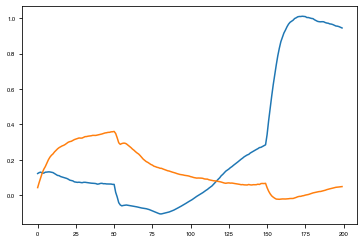

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

from psychrnn.backend.models.basic import Basic

# ---------------------- Set up a basic model ---------------------------
pd = SimplePD(dt = 10, tau = 100, T = 2000, N_batch = 128)
network_params = pd.get_task_params() # get the params passed in and defined in pd
network_params['name'] = 'model' # name the model uniquely if running mult models in unison
network_params['N_rec'] = 50 # set the number of recurrent units in the model
model = Basic(network_params) # instantiate a basic vanilla RNN

# ---------------------- Train a basic model ---------------------------
model.train(pd) # train model to perform pd task

# ---------------------- Test the trained model ---------------------------
x,target_output,mask, trial_params = pd.get_trial_batch() # get pd task inputs and outputs
model_output, model_state = model.test(x) # run the model on input x

# ---------------------- Plot the results ---------------------------
plt.plot(model_output[0][0,:,:])

# ---------------------- Teardown the model -------------------------
model.destruct()